In [ ]:
!pip install pytorch-lightning
!pip install lightning-bolts

In [ ]:
import math
import os
import logging
import numpy as np
from matplotlib import pyplot as plt
import imageio

import torch
from torch import nn, tensor
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset

from torchvision import transforms
from torchvision.datasets import MNIST

import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.loggers.neptune import NeptuneLogger
from pl_bolts.models.vision import UNet as BoltsUNet

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_path = "/content/drive/MyDrive"
examples_dir = f"{drive_path}/imc-prediction/examples"
checkpoints_dir = f"{drive_path}/imc-prediction/checkpoints"

In [ ]:
print(len(os.listdir(f"{examples_dir}/train/inputs")))
print(len(os.listdir(f"{examples_dir}/train/targets")))
print(len(os.listdir(f"{examples_dir}/test/inputs")))
print(len(os.listdir(f"{examples_dir}/test/targets")))

152
152
66
66


In [ ]:
class ImcDataset(Dataset):
    def __init__(self, train=True):
        self.dir = f"{examples_dir}/train" if train else f"{examples_dir}/test"
        self.example_names = sorted(os.listdir(f"{self.dir}/targets"))

    def __len__(self):
        return 6
        #return len(self.example_names)

    def __getitem__(self, idx):
        example_name = self.example_names[idx]
        input_img_name = f"{self.dir}/inputs/{example_name.replace('-ROI_', '-roi_')}.png"
        inp = torch.tensor(imageio.imread(input_img_name))[:, :, :1] / 255
        target_img_names = [
            f"{self.dir}/targets/{example_name}/{channel_filename}"
            for channel_filename in sorted(os.listdir(f"{self.dir}/targets/{example_name}"))
        ]
        targets = [torch.tensor(imageio.imread(name))[:, :, 0] for name in target_img_names]
        # TODO: continuous output - treat as regression or as class probabilities?
        binary_targets = [(target > 0).long() for target in targets]
        target = binary_targets[target_img_names.index(f"{self.dir}/targets/{example_name}/CollagenTypeI(Tm169).png")]  # using just one target channel for now
        # crop to certain size?
        # inputs are slightly shorter than targets, so we take
        # a few pixels off the top and bottom of the targets:
        extra_target_height = target.shape[0] - inp.shape[0]
        remove_from_top = math.floor(extra_target_height / 2)
        remove_from_bottom = math.ceil(extra_target_height / 2)
        target = target[remove_from_top:-remove_from_bottom]
        return inp.permute(2, 0, 1), target

In [ ]:
NEPTUNE_API_TOKEN = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOTAxYWFmNWItYTZmOC00YTZiLThjNWItNThkMmQ5YTY5OWVjIn0="

In [ ]:
console_logger = logging.getLogger("lightning")
console_logger.setLevel(logging.DEBUG)

In [ ]:
class MyUNet(pl.LightningModule):
    def __init__(
        self,
        #input_size=alphabet_size,
        #hidden_size=128,
        #num_layers=1,
        #dropout=0,
        learning_rate=1e-3,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.unet = BoltsUNet(
            features_start=64,
            input_channels=1,
            num_layers=2,
            num_classes=2,
        )

    def forward(self, x):
        return self.unet(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        if batch_idx % 5 == 0:
            console_logger.info("batch {}: train_loss {:.2f}".format(batch_idx, loss))
        #self.log(
        #    "train_loss2",
        #    loss,
        #    on_step=True,
        #    on_epoch=True,
        #    prog_bar=True,
        #    logger=False,
        #)
        #self.log(
        #    "train_loss",
        #    loss,
        #    on_step=True,
        #    on_epoch=True,
        #    prog_bar=True,
        #    logger=True,
        #)
        #self.logger.experiment.log_metric("train_loss", loss)
        return loss

    #def validation_step(self, batch, batch_idx):
    #    x, y = batch
    #    y_hat = self.model(x)
    #    loss = F.cross_entropy(y_hat, y)
    #    self.logger.experiment.log_metric("val_loss", loss)

    #    acc = FM.accuracy(y_hat, y)
    #    # loss is tensor. The Checkpoint Callback is monitoring "checkpoint_on"
    #    metrics = {"val_acc": acc, "val_loss": loss}
    #    self.log_dict(metrics)
    #    return metrics

    #def test_step(self, batch, batch_idx):
    #    metrics = self.validation_step(batch, batch_idx)
    #    metrics = {"test_acc": metrics["val_acc"], "test_loss": metrics["val_loss"]}
    #    self.log_dict(metrics)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

In [ ]:
class LoggingCallback(Callback):
    def on_train_epoch_start(self, trainer, pl_module):
        console_logger.info("train epoch: {}".format(trainer.current_epoch))
        
    def on_train_epoch_end(self, trainer, pl_module, outputs):
        console_logger.info("train epoch: {}".format(trainer.current_epoch))
        
    def on_validation_epoch_start(self, trainer, pl_module):
        console_logger.info("val epoch: {}".format(trainer.current_epoch))
        
    def on_validation_epoch_end(self, trainer, pl_module):
        console_logger.info("val epoch: {}".format(trainer.current_epoch))

In [ ]:
num_train = 5
#num_val = math.floor(num_train / 4)
batch_size = 1

train_loader = DataLoader(
    dataset=ImcDataset(train=True),
    batch_size=batch_size,
    num_workers=4,
    #pin_memory=True,
    #multiprocessing_context=torch.multiprocessing.get_context("spawn"),
)

#val_loader = DataLoader(
#    dataset=TensorDataset(val_inputs[:num_val], val_targets[:num_val]),
#    batch_size=batch_size,
#    #num_workers=8,
#    #pin_memory=True,
#)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model = MyUNet(
    #hidden_size=8,
    #num_layers=2,
    #dropout=0.5,
)

In [ ]:
#logger = NeptuneLogger(
#    api_key = NEPTUNE_API_TOKEN,
#    project_name = "bzrry/unet-test",
#    params = {**model.hparams, "num_train": num_train},
#    close_after_fit=False,
#)

trainer = pl.Trainer(
    max_epochs=3,
    #logger=logger,
    callbacks=[LoggingCallback()],
    log_every_n_steps=1,
    gpus=1,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | unet | UNet | 403 K 
------------------------------
403 K     Trainable params
0         Non-trainable params
403 K     Total params
1.615     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1

In [ ]:
#model.load_state_dict(torch.load(f"{checkpoints_dir}/model_dict.ckpt"))

In [ ]:
#torch.save(model.state_dict(), f"{checkpoints_dir}/model_dict.ckpt")

In [ ]:
sm = nn.Softmax(dim=2)
results = []
for x, y in train_loader:
  res = model(x)[0].permute(1, 2, 0)
  res = sm(res)
  res = res[:, :, 1].detach().numpy()
  results.append(res)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<Figure size 432x288 with 0 Axes>

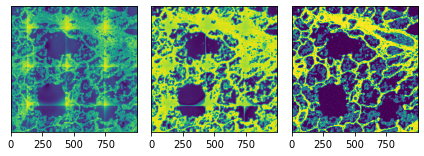

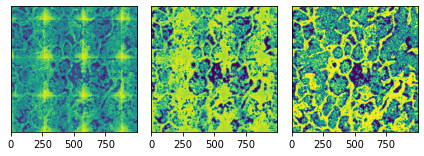

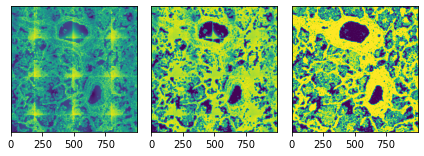

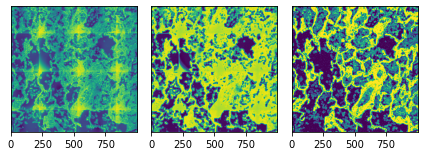

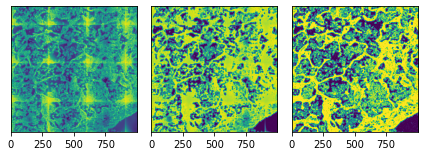

In [ ]:
for i, (x, y) in enumerate(train_loader):
    plt.figure(i)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(x[0][0])
    ax2.imshow(results[i])
    ax3.imshow(y[0])
    ax1.set_yticks([])
    ax2.set_yticks([])
    ax3.set_yticks([])
    fig.tight_layout()

In [ ]:
print(results[0])

[[0.5436122  0.5322599  0.5161888  ... 0.5925961  0.5965804  0.63594615]
 [0.52773046 0.57821375 0.5933508  ... 0.6224571  0.6200308  0.5993113 ]
 [0.4834981  0.5117689  0.5337663  ... 0.7542901  0.6844408  0.6205426 ]
 ...
 [0.5991396  0.6094185  0.6604718  ... 0.7430239  0.7469996  0.6916789 ]
 [0.6119673  0.60273635 0.6252801  ... 0.729159   0.6841199  0.65697616]
 [0.6122948  0.616018   0.6476321  ... 0.7043725  0.6757072  0.63688374]]


In [ ]:
print(train_loader.dataset[3][1].shape)

torch.Size([995, 1000])


In [ ]:
#neptune.log_artifact("model_dict.ckpt")

In [ ]:
#logger.experiment.stop()

In [ ]:
# automatically loads the best weights
#trainer.test(test_dataloaders=test_dataloader)

# call with pretrained model
#model = MyLSTM.load_from_checkpoint(PATH)
#trainer = pl.Trainer()
#trainer.test(model, test_dataloaders=test_dataloader)

In [ ]:
# merge two panoramas; average the two versions of each output channel
# having probabilities instead of 1/0 matches predictions better?
# or no because we're outputting each pixel as a range?
# are we doing regression or classification on pixels?